# TITLE

"ESTIMACION SOBRE LAS NECESIDADES DEL AREA DE SERVICIOS SOCIALES DEL AYUNTAMIENTO DE MADRID EN RELACION CON LAS URGENCIAS DE SERVICIOS" 

## SUBJECT:

"REALIZAR UNA CLASIFICACIÓN EN FUNCIÓN DE LAS CARACTERÍSTICAS MÁS IMPORTANTES DE LOS DATASETS DEL AYTO. DE MADRID DE LAS URGENCIAS ATENDIDAS EN LOS CENTROS DE ATENCIÓN PRIMARIA PARA TIPIFICAR EL TIPO DE AYUDA DE URGENCIA QUE NECESITARÁN.

CON ESTO PRETENDEMOS QUE AL LLEGAR UNA SOLICITUD DE URGENCIA A UN CENTRO PUEDAN IR PREPARANDO LOS RECURSOS HUMANOS Y NO HUMANOS PARA AGILIZAR TODOS LOS PROCESOS REQUERIDOS EN CADA TIPO DE AYUDA."

"HACER UNA ESTIMACION GLOBAL Y PARCIAL DE LAS NECESIDADES A ATENDER EN EL AREA DE SERVICIOS SOCIALES DEL AYUNTAMIENTO DE MADRID"

Se tomarán los datos de los últimos años y se realizará un estudio tomando como referencia *julio de 2021*, ya que no hay datos posteriores.

### HYPOTHESIS:
hipotesis_1 = "Es posible establecer un patrón de usuarios que van a solicitar alguna urgencia para poder atender mejor y más eficientemente modo a éstos."

hipotesis_2 = "Es necesario establecer algún tipo de esatudio temporal que permita optimizar los recursos del Area de Servicios Sociales?"

### 1.- Data Collection:

La fuente principal de todos los datos obtenidos ha sido a través de las páginas del ayuntamiento de Madrid:

MUNIMADRID y PORTAL DE DATOS ABIERTOS DEL AYUNTAMIENTO DE MADRID)

URL_urgencias_atendidas = <https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=0b006dace9578610VgnVCM1000001d4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default>

Las urgencias que se atienden en el Ayuntamiento son 5 y están clasificadas del siguiente modo:

  >Malos tratos:                            --      Código: 10
  >
  >Abandono                                 --      Código: 20
  >
  >Alojamiento/Vivienda                     --      Código: 30
  >
  >Desprotección social problema salud      --      Código: 40
  >
  >Desprotección socio-familiar             --      Código: 50




In [ ]:
'''
Para este projecto usaremos las siguientes librerías:
'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle 
'''
También nos harán falta las siguientes librerías de sklearn
'''
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score,confusion_matrix

### 2.- Data Extraction from different Datasets and storage in data\Outcomes

Vamos a tomar los datos de los años __desde el 2018 al 2021__.

Los datos de este último año no están completos. Solo hay hasta el mes de Julio.

In [4]:
df_2021=pd.read_csv("E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\Incomes\servicios_sociales_urgencias_2021.csv",sep=';',encoding='ISO-8859-1',index_col='Secuencia')   
#Este  dataset solo contine información hasta julio de 2021
df_2020=pd.read_csv("E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\Incomes\servicios_sociales_urgencias_2020.csv",sep=';',encoding='utf-8',index_col='Secuencia')

df_2019=pd.read_csv("E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\Incomes\servicios_sociales_urgencias_2019.csv",sep=';',encoding='ISO-8859-1',index_col='Secuencia')

df_2018=pd.read_csv("E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\Incomes\servicios_sociales_urgencias_2018.csv",sep=';',encoding='ISO-8859-1',index_col='Secuencia')

In [ ]:
df_urgencias=pd.concat([df_2021,df_2020,df_2019,df_2018], ignore_index=True)
df_urgencias

In [ ]:
df_urgencias.drop(['Código Distrito','Distrito','Código Barrio','Barrio','Sección Censal'],axis=1,inplace=True)
df_urgencias

In [7]:
df_urgencias.to_csv('E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\Outcomes\df_urgencias.csv',header=True,index=False)

### 3.- Featuring Engineering

In [ ]:
df_urgencias= pd.read_csv("E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\Outcomes\df_urgencias.csv",sep=',')
df_urgencias

Vamos a agrupar las __fechas de edades__ para tener un rango más manejable.

Así agruparemos < 18 años a todos los grupos que sean inferiores a esta edad.

Agruparemos >65 a todos los grupos que sean superiores a esta edad.

Agruparemos de 10 en 10 años al resto.

In [9]:
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace(' - ','-')
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace('- ','-')
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace('= ','=')

In [ ]:
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A4-11", "<=18")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A12-17", "<=18")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A0-3", "<=18") 

df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A18-24", "19-29")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A25-29", "19-29")

df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A30-34", "30-39")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A35-39", "30-39")

df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A40-44", "40-49")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A44-49", "40-49")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A45-49", "40-49")

df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A50-54", "50-59")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A55-59", "50-59")

df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A60-64", "60-64")

df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A65-69", ">=65")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A75-79", ">=65")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A80-84", ">=65")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A70-74", ">=65")
df_urgencias['Tramo Edad']=df_urgencias['Tramo Edad'].str.replace("\A>=85", ">=65")

#df_demandas


In [12]:
df_urgencias['Tramo Edad'].value_counts()

>=65     11898
30-39     7673
40-49     7310
50-59     4684
19-29     4421
60-64     1634
<=18       212
            74
Name: Tramo Edad, dtype: int64

In [13]:
lista_rango_edad=df_urgencias['Tramo Edad'].unique()                  # Hay que revisar esto, porque no está ordenado y sería lo ideal
lista_rango_edad.sort()
mivalor = [ x for x in range(len(lista_rango_edad))]             ##  agregaremos una variable numérica para sustituir a los nombres de las cias
mivalor
lista_rango_edad=list(lista_rango_edad)                               ##  dejamos el valor cero por si en los datos a testear  hay algún NaN y 

Age_range_code = {k: v for k, v in zip(lista_rango_edad, mivalor)}   ##  sustituirlo por cero
Age_range_code
df_urgencias['Age_range_code']= df_urgencias['Tramo Edad'].map(Age_range_code)

Los valores son: {nulos: 0, 19-29: 1, 30-39: 2, 40-49: 3, 50-59: 4, 60-64: 5, <=18: 6, >=65: 7}

Vamos a dar un formato numérico a la __nacionalidad__ del usuario, siendo los valores: 

0 para Española, 1 para Extranjera

In [15]:
lista_nacionalidad=df_urgencias['Nacionalidad'].unique()
lista_nacionalidad.sort()
lista_nacionalidad
mivalor = [ x for x in range(len(lista_nacionalidad))]             ##  agregaremos una variable numérica para sustituir a los nombres de las cias
#mivalor    
lista_nacionalidad=list(lista_nacionalidad)                               ##  dejamos el valor cero por si en los datos a testear  hay algún NaN y 
Nationality_code = {k: v for k, v in zip(lista_nacionalidad, mivalor)}   ##  sustituirlo por cero
df_urgencias['Nationality_code']= df_urgencias['Nacionalidad'].map(Nationality_code)


In [16]:
df_urgencias['Sexo'].value_counts()             #Solo hay 1 dato vacio en el DataFrame por lo que lo sustituiremos por M, que es la moda

M    26565
H    11339
         2
Name: Sexo, dtype: int64

In [17]:
df_urgencias['Sexo']=df_urgencias['Sexo'].mask(df_urgencias['Sexo'] == ' ').fillna('M')

Vamos a dar un formato numérico al __sexo__ del usuario, siendo los valores: 

0 para H, 1 para M

In [18]:
lista_sexo=df_urgencias['Sexo'].unique()
lista_sexo.sort()
lista_sexo
mivalor = [ x for x in range(len(lista_sexo))]             ##  agregaremos una variable numérica para sustituir a los nombres de las cias
#mivalor    
lista_sexo=list(lista_sexo)                               ##  dejamos el valor cero por si en los datos a testear  hay algún NaN y 

Sex_code = {k: v for k, v in zip(lista_sexo, mivalor)}   ##  sustituirlo por cero

df_urgencias['Sex_code']= df_urgencias['Sexo'].map(Sex_code)


In [19]:
df_urgencias['Tipo Supuesto Urgente'].unique()          #   Vemos que hay valores nulos en el campo a valorar, por lo que vamos a ver cuantos son y ver la posibilidad de sustituirlos por otros.
                                                        #   Esto lo haremos en cada Dataset descargado para así que sea más "asumible" la tarea

array(['Alojamiento/Vivienda', 'Desproteccion social problema salud',
       'Desprotección socio-familiar', 'Malos Tratos', 'Abandono', nan],
      dtype=object)

In [20]:
df_urgencias['Tipo Supuesto Urgente'].isnull().sum()

2184

Se puede ver que hay muchos en esta columna con __NaN__ (2184).

Vamos a dar un formato de fecha año y trimestre a los valores de 'Fecha Demanda' para poder ver qué evolución tienen los datos en el tiempo.

In [ ]:
df_urgencias['Fecha Cita'] = pd.to_datetime(df_urgencias['Fecha Cita'], dayfirst=True)

df_urgencias['year'] = df_urgencias['Fecha Cita'].dt.year
#df_demandas['month'] = df_demandas['Timestamp'].dt.month
df_urgencias['Quarteryear'] = df_urgencias['Fecha Cita'].dt.quarter
df_urgencias

In [22]:
df_urgencias_prueba=df_urgencias.drop(['Código Centro'],axis=1)
col = df_urgencias_prueba.pop('Código Tipo Supuesto Urgente')
df_urgencias_prueba.insert(loc= 0 , column= 'Código Tipo Supuesto Urgente', value= col)

In [ ]:
df_urgencias_prueba.info()

Como podemos observar no están todos los valores de __'Código Tipo Supuesto Urgente'__ ni de __'Tipo Supuesto Urgente'__, por lo que nos vemos obligados a realizar un nuevo proceso de ingeniería de datos para darles un valor a estas columnas, que serán la variable dependiente o target.

Para esto realizaremos nuevamente el proceso a partir de los DataSets originales y volveremos a realizar toda esta ingeniería.

### 4.- Reconstruction Dataframes

In [24]:
df_2021_correccion=df_2021
df_2021_correccion.describe(include='all')                  #   Vamos a ver las características de las columnas 'Código Tipo Supuesto Urgente' y 'Tipo Supuesto Urgente',
                                                            #   que están relacionadas entre sí y dónde están los valores NaN que hay que sustituir.

,Código Centro,Centro,Código Distrito Centro,Distrito Centro,Código Distrito,Distrito,Código Barrio,Barrio,Sección Censal,Tramo Edad,Nacionalidad,Sexo,Código Tipo Atención,Tipo Atención,Código Tipo Supuesto Urgente,Tipo Supuesto Urgente,Fecha Cita
count,2626.000000,2626,2626.000000,2626,2626,2626,2626,2626,2626,2626,2626,2626,2626.000000,2626,2460.000000,2460,2626
unique,NaN,38,NaN,21,22,22,123,123,213,18,3,3,NaN,3,NaN,5,134
top,NaN,CSS San Diego,NaN,PUENTE DE VALLECAS,13,PUENTE DE VALLECAS,1302,SAN DIEGO,063,>= 85,Española,M,NaN,Zona / Historia Social,NaN,Desproteccion social problema salud,28/06/2021
freq,NaN,242,NaN,429,426,426,161,161,32,473,1696,1718,NaN,1555,NaN,1069,40
mean,87.120716,NaN,10.778370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.580350,NaN,35.674797,NaN,NaN
std,11.616322,NaN,4.684117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.516968,NaN,8.886337,NaN,NaN
min,69.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,10.000000,NaN,NaN
25%,78.000000,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,30.000000,NaN,NaN
50%,86.000000,NaN,11.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,40.000000,NaN,NaN
75%,93.000000,NaN,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,40.000000,NaN,NaN


In [25]:
print("Los valores NaN que hay en este Dataset son: ",df_2021['Código Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2021))
df_2021['Código Tipo Supuesto Urgente'].value_counts()

Los valores NaN que hay en este Dataset son:  166
Los registros que hay en este DataSet son:  2626


40.0    1069
30.0     968
50.0     291
10.0     123
20.0       9
Name: Código Tipo Supuesto Urgente, dtype: int64

In [ ]:
df_2021_correccion['Código Tipo Supuesto Urgente'].fillna(method="ffill",inplace=True)
df_2021_correccion['Tipo Supuesto Urgente'].fillna(method="ffill",inplace=True)
'''Verificamos'''
print("Los valores NaN que hay en este Dataset son: ",df_2021_correccion['Código Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2021_correccion))
df_2021['Código Tipo Supuesto Urgente'].value_counts()
print("Los valores NaN que hay en este Dataset son: ",df_2021_correccion['Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2021_correccion))
df_2021_correccion['Tipo Supuesto Urgente'].value_counts()

En este Dataframe vemos que la media de **'Código Tipo Supuesto Urgente'** se aproxima a la mediana.

Este tipo de dato, aunque es numérico, es categorico y solo tienen valores de 10,20,30,40 y 50.

Hay 166 datos vacíos, los rellenaremos con los datos del registro anterior.

In [37]:
df_2021_correccion.groupby('Código Tipo Supuesto Urgente')['Tipo Supuesto Urgente'].value_counts()

Código Tipo Supuesto Urgente  Tipo Supuesto Urgente              
10.0                          Malos Tratos                            134
20.0                          Abandono                                 10
30.0                          Alojamiento/Vivienda                   1037
40.0                          Desproteccion social problema salud    1133
50.0                          Desprotección socio-familiar            312
Name: Tipo Supuesto Urgente, dtype: int64

In [29]:
df_2020_correccion=df_2020
df_2020_correccion.describe(include='all')                  #   Vamos a ver las características de las columnas 'Código Tipo Supuesto Urgente' y 'Tipo Supuesto Urgente',
                                                            #   que están relacionadas entre sí y dónde están los valores NaN que hay que sustituir.

,Código Centro,Centro,Código Distrito Centro,Distrito Centro,Código Distrito,Distrito,Código Barrio,Barrio,Sección Censal,Tramo Edad,Nacionalidad,Sexo,Código Tipo Atención,Tipo Atención,Código Tipo Supuesto Urgente,Tipo Supuesto Urgente,Fecha Cita
count,24351.000000,24351,24351.000000,24351,24351.000000,24351,24351.000000,24351,24351.000000,24351,24351,24351,24351.000000,24351,22949.000000,22949,24351
unique,NaN,38,NaN,21,NaN,21,NaN,125,NaN,18,2,2,NaN,3,NaN,5,249
top,NaN,CSS María Zayas,NaN,TETUÁN,NaN,TETUÁN,NaN,VALDECEDERAS,NaN,40 - 44,Extranjera,M,NaN,Zona / Historia Social,NaN,Desprotección socio-familiar,20/04/2020
freq,NaN,6281,NaN,11884,NaN,11694,NaN,2691,NaN,3070,14944,17398,NaN,14257,NaN,16475,373
mean,85.428648,NaN,7.238799,NaN,7.319289,NaN,735.633773,NaN,72.913515,NaN,NaN,NaN,1.575418,NaN,45.991546,NaN,NaN
std,12.486296,NaN,2.878543,NaN,2.995551,NaN,299.596304,NaN,43.083262,NaN,NaN,NaN,0.514243,NaN,7.414501,NaN,NaN
min,69.000000,NaN,1.000000,NaN,1.000000,NaN,101.000000,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,10.000000,NaN,NaN
25%,75.000000,NaN,6.000000,NaN,6.000000,NaN,603.000000,NaN,36.000000,NaN,NaN,NaN,1.000000,NaN,40.000000,NaN,NaN
50%,77.000000,NaN,6.000000,NaN,6.000000,NaN,606.000000,NaN,75.000000,NaN,NaN,NaN,2.000000,NaN,50.000000,NaN,NaN
75%,101.000000,NaN,8.000000,NaN,8.000000,NaN,804.000000,NaN,105.000000,NaN,NaN,NaN,2.000000,NaN,50.000000,NaN,NaN


In [30]:
print("Los valores NaN que hay en este Dataset son: ",df_2020['Código Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2020))
df_2020['Código Tipo Supuesto Urgente'].value_counts()

Los valores NaN que hay en este Dataset son:  1402
Los registros que hay en este DataSet son:  24351


50.0    16475
40.0     4308
30.0     1875
10.0      268
20.0       23
Name: Código Tipo Supuesto Urgente, dtype: int64

En este Dataframe vemos que la mediana de **'Código Tipo Supuesto Urgente'** tiene muchos valores en 50 y la media está entre 40 y 50 también, lo que indica que en general casi todos los registros se situan entre 40 y 50.

Este tipo de dato, aunque es numérico, es categorico y solo tienen valores de 10,20,30,40 y 50.

Hay 1402 datos vacíos, los rellenaremos con los datos del registro anterior, que principalmente serán éstos.

In [32]:
df_2020_correccion['Código Tipo Supuesto Urgente'].fillna(method="ffill",inplace=True)
df_2020_correccion['Tipo Supuesto Urgente'].fillna(method="ffill",inplace=True)
'''Verificamos'''
print("Los valores NaN que hay en este Dataset son: ",df_2020_correccion['Código Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2020_correccion))
print("Los valores NaN que hay en este Dataset son: ",df_2020_correccion['Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2020_correccion))
df_2020_correccion.groupby('Código Tipo Supuesto Urgente')['Tipo Supuesto Urgente'].value_counts()

Los valores NaN que hay en este Dataset son:  0
Los registros que hay en este DataSet son:  24351
Los valores NaN que hay en este Dataset son:  0
Los registros que hay en este DataSet son:  24351


Código Tipo Supuesto Urgente  Tipo Supuesto Urgente              
10.0                          Malos Tratos                             290
20.0                          Abandono                                  23
30.0                          Alojamiento/Vivienda                    2016
40.0                          Desproteccion social problema salud     4539
50.0                          Desprotección socio-familiar           17483
Name: Tipo Supuesto Urgente, dtype: int64

In [33]:
df_2019_correccion=df_2019
df_2019_correccion.describe(include='all')                  #   Vamos a ver las características de las columnas 'Código Tipo Supuesto Urgente' y 'Tipo Supuesto Urgente',
                                                            #   que están relacionadas entre sí y dónde están los valores NaN que hay que sustituir.

,Código Centro,Centro,Código Distrito Centro,Distrito Centro,Código Distrito,Distrito,Código Barrio,Barrio,Sección Censal,Tramo Edad,Nacionalidad,Sexo,Código Tipo Atención,Tipo Atención,Código Tipo Supuesto Urgente,Tipo Supuesto Urgente,Fecha Cita
count,5298.000000,5298,5298.000000,5298,5298.000000,5298,5298,5298,5298.000000,5298,5298,5298,5298.000000,5298,5000.000000,5000,5298
unique,NaN,38,NaN,21,NaN,21,126,126,NaN,18,2,3,NaN,3,NaN,5,247
top,NaN,CSS San Diego,NaN,PUENTE DE VALLECAS,NaN,PUENTE DE VALLECAS,1302,SAN DIEGO,NaN,>= 85,Española,M,NaN,Zona / Historia Social,NaN,Desproteccion social problema salud,09/10/2019
freq,NaN,365,NaN,725,NaN,727,230,230,NaN,1037,3365,3682,NaN,3412,NaN,2128,35
mean,87.083994,NaN,10.750094,NaN,10.800302,NaN,NaN,NaN,78.555304,NaN,NaN,NaN,1.613817,NaN,35.584000,NaN,NaN
std,12.048872,NaN,4.884761,NaN,4.893480,NaN,NaN,NaN,53.404354,NaN,NaN,NaN,0.545438,NaN,8.865363,NaN,NaN
min,69.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,10.000000,NaN,NaN
25%,79.000000,NaN,8.000000,NaN,8.000000,NaN,NaN,NaN,37.000000,NaN,NaN,NaN,1.000000,NaN,30.000000,NaN,NaN
50%,85.000000,NaN,11.000000,NaN,11.000000,NaN,NaN,NaN,69.000000,NaN,NaN,NaN,2.000000,NaN,40.000000,NaN,NaN
75%,94.000000,NaN,13.000000,NaN,13.000000,NaN,NaN,NaN,112.000000,NaN,NaN,NaN,2.000000,NaN,40.000000,NaN,NaN


In [36]:
print("Los valores NaN que hay en este Dataset son: ",df_2019['Código Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2019))
df_2019['Código Tipo Supuesto Urgente'].value_counts()

Los valores NaN que hay en este Dataset son:  298
Los registros que hay en este DataSet son:  5298


40.0    2128
30.0    2020
50.0     588
10.0     248
20.0      16
Name: Código Tipo Supuesto Urgente, dtype: int64

En este Dataframe vemos que la mediana de **'Código Tipo Supuesto Urgente'** tiene muchos valores en 40 y la media está entre 30 y 40 también, lo que indica que en general casi todos los registros se situan entre 30 y 40.

Este tipo de dato, aunque es numérico, es categorico y solo tienen valores de 10,20,30,40 y 50.

Hay 298 datos vacíos, los rellenaremos con los datos del registro anterior, que principalmente serán éstos.

In [38]:
df_2019_correccion['Código Tipo Supuesto Urgente'].fillna(method="ffill",inplace=True)
df_2019_correccion['Tipo Supuesto Urgente'].fillna(method="ffill",inplace=True)
'''Verificamos'''
print("Los valores NaN que hay en este Dataset son: ",df_2019_correccion['Código Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2019_correccion))
print("Los valores NaN que hay en este Dataset son: ",df_2019_correccion['Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2019_correccion))
df_2019_correccion.groupby('Código Tipo Supuesto Urgente')['Tipo Supuesto Urgente'].value_counts()

Los valores NaN que hay en este Dataset son:  0
Los registros que hay en este DataSet son:  5298
Los valores NaN que hay en este Dataset son:  0
Los registros que hay en este DataSet son:  5298


Código Tipo Supuesto Urgente  Tipo Supuesto Urgente              
10.0                          Malos Tratos                            264
20.0                          Abandono                                 19
30.0                          Alojamiento/Vivienda                   2149
40.0                          Desproteccion social problema salud    2244
50.0                          Desprotección socio-familiar            622
Name: Tipo Supuesto Urgente, dtype: int64

In [39]:
df_2018_correccion=df_2018
df_2018_correccion.describe(include='all')                  #   Vamos a ver las características de las columnas 'Código Tipo Supuesto Urgente' y 'Tipo Supuesto Urgente',
                                                            #   que están relacionadas entre sí y dónde están los valores NaN que hay que sustituir.

,Código Centro,Centro,Código Distrito Centro,Distrito Centro,Código Distrito,Distrito,Código Barrio,Barrio,Sección Censal,Tramo Edad,Nacionalidad,Sexo,Código Tipo Atención,Tipo Atención,Código Tipo Supuesto Urgente,Tipo Supuesto Urgente,Fecha Cita
count,5631.000000,5631,5631.000000,5631,5631.000000,5631,5631,5631,5631.000000,5631,5631,5631,5631.000000,5631,5313.000000,5313,5631
unique,NaN,38,NaN,21,NaN,21,127,127,NaN,18,2,2,NaN,3,NaN,5,247
top,NaN,CSS Badalona,NaN,LATINA,NaN,LATINA,1004,ALUCHE,NaN,>= 85,Española,M,NaN,Zona / Historia Social,NaN,Desproteccion social problema salud,10/10/2018
freq,NaN,386,NaN,672,NaN,670,255,255,NaN,1193,3782,3767,NaN,3660,NaN,2297,41
mean,85.908364,NaN,10.375244,NaN,10.372225,NaN,NaN,NaN,73.962351,NaN,NaN,NaN,1.611614,NaN,36.002259,NaN,NaN
std,11.848696,NaN,5.071813,NaN,5.089079,NaN,NaN,NaN,50.632609,NaN,NaN,NaN,0.560639,NaN,8.960337,NaN,NaN
min,69.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,10.000000,NaN,NaN
25%,77.000000,NaN,8.000000,NaN,8.000000,NaN,NaN,NaN,34.000000,NaN,NaN,NaN,1.000000,NaN,30.000000,NaN,NaN
50%,84.000000,NaN,11.000000,NaN,11.000000,NaN,NaN,NaN,65.000000,NaN,NaN,NaN,2.000000,NaN,40.000000,NaN,NaN
75%,94.000000,NaN,13.000000,NaN,13.000000,NaN,NaN,NaN,106.000000,NaN,NaN,NaN,2.000000,NaN,40.000000,NaN,NaN


In [40]:
print("Los valores NaN que hay en este Dataset son: ",df_2018['Código Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2018))
df_2018['Código Tipo Supuesto Urgente'].value_counts()

Los valores NaN que hay en este Dataset son:  318
Los registros que hay en este DataSet son:  5631


40.0    2297
30.0    2023
50.0     712
10.0     251
20.0      30
Name: Código Tipo Supuesto Urgente, dtype: int64

En este Dataframe vemos que la mediana y la media de **'Código Tipo Supuesto Urgente'** tienen valores en torno a 40 (siendo está la mediana), pero el reparto es más amplio.

Este tipo de dato, aunque es numérico, es categorico y solo tienen valores de 10,20,30,40 y 50.

Hay 318 datos vacíos, los rellenaremos con los datos del registro anterior, que principalmente serán éstos.

In [41]:
df_2018_correccion['Código Tipo Supuesto Urgente'].fillna(method="ffill",inplace=True)
df_2018_correccion['Tipo Supuesto Urgente'].fillna(method="ffill",inplace=True)
'''Verificamos'''
print("Los valores NaN que hay en este Dataset son: ",df_2018_correccion['Código Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2018_correccion))
print("Los valores NaN que hay en este Dataset son: ",df_2018_correccion['Tipo Supuesto Urgente'].isnull().sum())
print("Los registros que hay en este DataSet son: ",len(df_2018_correccion))
df_2018_correccion.groupby('Código Tipo Supuesto Urgente')['Tipo Supuesto Urgente'].value_counts()

Los valores NaN que hay en este Dataset son:  0
Los registros que hay en este DataSet son:  5631
Los valores NaN que hay en este Dataset son:  0
Los registros que hay en este DataSet son:  5631


Código Tipo Supuesto Urgente  Tipo Supuesto Urgente              
10.0                          Malos Tratos                            269
20.0                          Abandono                                 31
30.0                          Alojamiento/Vivienda                   2129
40.0                          Desproteccion social problema salud    2432
50.0                          Desprotección socio-familiar            770
Name: Tipo Supuesto Urgente, dtype: int64

In [ ]:
df_urgencias_correccion=pd.concat([df_2020_correccion,df_2019_correccion,df_2018_correccion], ignore_index=True)
df_urgencias_correccion

In [43]:
df_urgencias_correccion.drop(['Código Distrito','Distrito','Código Barrio','Barrio','Sección Censal'],axis=1,inplace=True)
df_urgencias_correccion.to_csv('E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\Outcomes\df_urgencias_corregido.csv',header=True,index=False)

### 5 - Data Engineering

Vamos a agrupar las __fechas de edades__ para tener un rango más manejable.

Así agruparemos < 18 años a todos los grupos que sean inferiores a esta edad.

Agruparemos >65 a todos los grupos que sean superiores a esta edad.

Agruparemos de 10 en días años al resto.

In [44]:
df_urgencias_corregido= pd.read_csv("E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\Outcomes\df_urgencias_corregido.csv",sep=',')
df_urgencias_corregido

,Código Centro,Centro,Código Distrito Centro,Distrito Centro,Tramo Edad,Nacionalidad,Sexo,Código Tipo Atención,Tipo Atención,Código Tipo Supuesto Urgente,Tipo Supuesto Urgente,Fecha Cita
0,69,CSS José Villarreal,2,ARGANZUELA,50 - 54,Española,H,1,Primera Atención,50.0,Desprotección socio-familiar,02/01/2020
1,69,CSS José Villarreal,2,ARGANZUELA,>= 85,Española,M,2,Zona / Historia Social,40.0,Desproteccion social problema salud,02/01/2020
2,69,CSS José Villarreal,2,ARGANZUELA,60 - 64,Extranjera,H,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,02/01/2020
3,69,CSS José Villarreal,2,ARGANZUELA,75 - 79,Española,H,1,Primera Atención,40.0,Desproteccion social problema salud,02/01/2020
4,99,CSS Teresa de Calcuta,21,BARAJAS,40 - 44,Española,M,2,Zona / Historia Social,50.0,Desprotección socio-familiar,02/01/2020
...,...,...,...,...,...,...,...,...,...,...,...,...
35275,98,CSS Pablo Casals,20,SAN BLAS-CANILLEJAS,30 - 34,Española,M,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,28/12/2018
35276,85,CSS Loyola de Palacio,12,USERA,>= 85,Española,M,2,Zona / Historia Social,40.0,Desproteccion social problema salud,28/12/2018
35277,84,CSS San Filiberto,12,USERA,35 - 39,Extranjera,M,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,28/12/2018
35278,84,CSS San Filiberto,12,USERA,65 - 69,Española,H,1,Primera Atención,30.0,Alojamiento/Vivienda,28/12/2018


In [45]:
df_urgencias_corregido['Tramo Edad'].value_counts()

>= 85      4731
40 - 44    3941
35 - 39    3887
30 - 34    3418
45- 49     2980
50 - 54    2551
25 - 29    2471
80 - 84    2218
55 - 59    1804
18 - 24    1697
75 - 79    1492
60 - 64    1481
70 - 74    1247
65 - 69    1105
12 - 17     105
             70
4 - 11       61
0 - 3        21
Name: Tramo Edad, dtype: int64

Vemos que hay __70 registros en blanco__ que no hemos sustituido anteriormente.

Vamos a proceder a reemplazarlos por el registro anterior, ya que no afectará mucho a las previsiones del módelo.

In [46]:
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].mask(df_urgencias_corregido['Tramo Edad'] == ' ')
df_urgencias_corregido.fillna(method='ffill',inplace=True)

Hay que eliminar los espacios en blanco entre -

In [47]:
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace(' - ','-')
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace('- ','-')
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace('= ','=')

In [48]:
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A4-11", "<=18")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A12-17", "<=18")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A0-3", "<=18") 

df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A18-24", "19-29")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A25-29", "19-29")

df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A30-34", "30-39")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A35-39", "30-39")

df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A40-44", "40-49")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A44-49", "40-49")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A45-49", "40-49")

df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A50-54", "50-59")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A55-59", "50-59")

df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A60-64", "60-64")

df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A65-69", ">=65")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A75-79", ">=65")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A80-84", ">=65")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A70-74", ">=65")
df_urgencias_corregido['Tramo Edad']=df_urgencias_corregido['Tramo Edad'].str.replace("\A>=85", ">=65")

#df_demandas


c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6

In [49]:
'''Verificamos que ya no hay valores nulos'''
print(df_urgencias_corregido['Tramo Edad'].value_counts())
print("Los valores nulos que hay actualmente en este DataFrame son: ",df_urgencias_corregido['Tramo Edad'].isnull().sum())

>=65     10811
30-39     7321
40-49     6937
50-59     4363
19-29     4177
60-64     1484
<=18       187
Name: Tramo Edad, dtype: int64
Los valores nulos que hay actualmente en este DataFrame son:  0


Los valores son: {19-29: 0, 30-39: 1, 40-49: 2, 50-59: 3, 60-64: 4, <=18: 5, >=65: 6}

In [50]:
lista_rango_edad=df_urgencias_corregido['Tramo Edad'].unique()                  # Hay que revisar esto, porque no está ordenado y sería lo ideal
lista_rango_edad.sort()
mivalor = [ x for x in range(len(lista_rango_edad))]             ##  agregaremos una variable numérica para sustituir a los nombres de las cias
mivalor
lista_rango_edad=list(lista_rango_edad)                               ##  dejamos el valor cero por si en los datos a testear  hay algún NaN y 

Age_range_code = {k: v for k, v in zip(lista_rango_edad, mivalor)}   ##  sustituirlo por cero
Age_range_code
df_urgencias_corregido['Age_range_code']= df_urgencias_corregido['Tramo Edad'].map(Age_range_code)

Vamos a dar un formato numérico a la __nacionalidad__ del usuario, siendo los valores: 

0 para Española, 1 para Extranjera

In [51]:
lista_nacionalidad=df_urgencias_corregido['Nacionalidad'].unique()
lista_nacionalidad.sort()
lista_nacionalidad
mivalor = [ x for x in range(len(lista_nacionalidad))]             ##  agregaremos una variable numérica para sustituir a los nombres de las cias
#mivalor    
lista_nacionalidad=list(lista_nacionalidad)                               ##  dejamos el valor cero por si en los datos a testear  hay algún NaN y 
Nationality_code = {k: v for k, v in zip(lista_nacionalidad, mivalor)}   ##  sustituirlo por cero
df_urgencias_corregido['Nationality_code']=df_urgencias_corregido['Nacionalidad'].map(Nationality_code)
df_urgencias_corregido

,Código Centro,Centro,Código Distrito Centro,Distrito Centro,Tramo Edad,Nacionalidad,Sexo,Código Tipo Atención,Tipo Atención,Código Tipo Supuesto Urgente,Tipo Supuesto Urgente,Fecha Cita,Age_range_code,Nationality_code
0,69,CSS José Villarreal,2,ARGANZUELA,50-59,Española,H,1,Primera Atención,50.0,Desprotección socio-familiar,02/01/2020,3,0
1,69,CSS José Villarreal,2,ARGANZUELA,>=65,Española,M,2,Zona / Historia Social,40.0,Desproteccion social problema salud,02/01/2020,6,0
2,69,CSS José Villarreal,2,ARGANZUELA,60-64,Extranjera,H,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,02/01/2020,4,1
3,69,CSS José Villarreal,2,ARGANZUELA,>=65,Española,H,1,Primera Atención,40.0,Desproteccion social problema salud,02/01/2020,6,0
4,99,CSS Teresa de Calcuta,21,BARAJAS,40-49,Española,M,2,Zona / Historia Social,50.0,Desprotección socio-familiar,02/01/2020,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35275,98,CSS Pablo Casals,20,SAN BLAS-CANILLEJAS,30-39,Española,M,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,28/12/2018,1,0
35276,85,CSS Loyola de Palacio,12,USERA,>=65,Española,M,2,Zona / Historia Social,40.0,Desproteccion social problema salud,28/12/2018,6,0
35277,84,CSS San Filiberto,12,USERA,30-39,Extranjera,M,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,28/12/2018,1,1
35278,84,CSS San Filiberto,12,USERA,>=65,Española,H,1,Primera Atención,30.0,Alojamiento/Vivienda,28/12/2018,6,0


In [52]:
df_urgencias_corregido['Sexo'].value_counts()             #Solo hay 1 dato vacio en el DataFrame por lo que lo sustituiremos por M, que es la moda

M    24847
H    10432
         1
Name: Sexo, dtype: int64

In [53]:
df_urgencias_corregido['Sexo']=df_urgencias_corregido['Sexo'].mask(df_urgencias_corregido['Sexo'] == ' ').fillna('M')

Vamos a dar un formato numérico al __sexo__ del usuario, siendo los valores: 

0 para H, 1 para M

In [54]:
lista_sexo=df_urgencias_corregido['Sexo'].unique()
lista_sexo.sort()
lista_sexo
mivalor = [ x for x in range(len(lista_sexo))]             ##  agregaremos una variable numérica para sustituir a los nombres de las cias
#mivalor    
lista_sexo=list(lista_sexo)                               ##  dejamos el valor cero por si en los datos a testear  hay algún NaN y 

Sex_code = {k: v for k, v in zip(lista_sexo, mivalor)}   ##  sustituirlo por cero

df_urgencias_corregido['Sex_code']= df_urgencias_corregido['Sexo'].map(Sex_code)
df_urgencias_corregido

,Código Centro,Centro,Código Distrito Centro,Distrito Centro,Tramo Edad,Nacionalidad,Sexo,Código Tipo Atención,Tipo Atención,Código Tipo Supuesto Urgente,Tipo Supuesto Urgente,Fecha Cita,Age_range_code,Nationality_code,Sex_code
0,69,CSS José Villarreal,2,ARGANZUELA,50-59,Española,H,1,Primera Atención,50.0,Desprotección socio-familiar,02/01/2020,3,0,0
1,69,CSS José Villarreal,2,ARGANZUELA,>=65,Española,M,2,Zona / Historia Social,40.0,Desproteccion social problema salud,02/01/2020,6,0,1
2,69,CSS José Villarreal,2,ARGANZUELA,60-64,Extranjera,H,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,02/01/2020,4,1,0
3,69,CSS José Villarreal,2,ARGANZUELA,>=65,Española,H,1,Primera Atención,40.0,Desproteccion social problema salud,02/01/2020,6,0,0
4,99,CSS Teresa de Calcuta,21,BARAJAS,40-49,Española,M,2,Zona / Historia Social,50.0,Desprotección socio-familiar,02/01/2020,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35275,98,CSS Pablo Casals,20,SAN BLAS-CANILLEJAS,30-39,Española,M,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,28/12/2018,1,0,1
35276,85,CSS Loyola de Palacio,12,USERA,>=65,Española,M,2,Zona / Historia Social,40.0,Desproteccion social problema salud,28/12/2018,6,0,1
35277,84,CSS San Filiberto,12,USERA,30-39,Extranjera,M,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,28/12/2018,1,1,1
35278,84,CSS San Filiberto,12,USERA,>=65,Española,H,1,Primera Atención,30.0,Alojamiento/Vivienda,28/12/2018,6,0,0


Vamos a dar un formato de fecha año y trimestre a los valores de 'Fecha Demanda' para poder ver qué evolución tienen los datos en el tiempo

In [55]:
df_urgencias_corregido['Fecha Cita'] = pd.to_datetime(df_urgencias_corregido['Fecha Cita'], dayfirst=True)

df_urgencias_corregido['year'] = df_urgencias_corregido['Fecha Cita'].dt.year
#df_demandas['month'] = df_demandas['Timestamp'].dt.month
df_urgencias_corregido['Quarteryear'] = df_urgencias_corregido['Fecha Cita'].dt.quarter
df_urgencias_corregido

,Código Centro,Centro,Código Distrito Centro,Distrito Centro,Tramo Edad,Nacionalidad,Sexo,Código Tipo Atención,Tipo Atención,Código Tipo Supuesto Urgente,Tipo Supuesto Urgente,Fecha Cita,Age_range_code,Nationality_code,Sex_code,year,Quarteryear
0,69,CSS José Villarreal,2,ARGANZUELA,50-59,Española,H,1,Primera Atención,50.0,Desprotección socio-familiar,2020-01-02,3,0,0,2020,1
1,69,CSS José Villarreal,2,ARGANZUELA,>=65,Española,M,2,Zona / Historia Social,40.0,Desproteccion social problema salud,2020-01-02,6,0,1,2020,1
2,69,CSS José Villarreal,2,ARGANZUELA,60-64,Extranjera,H,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,2020-01-02,4,1,0,2020,1
3,69,CSS José Villarreal,2,ARGANZUELA,>=65,Española,H,1,Primera Atención,40.0,Desproteccion social problema salud,2020-01-02,6,0,0,2020,1
4,99,CSS Teresa de Calcuta,21,BARAJAS,40-49,Española,M,2,Zona / Historia Social,50.0,Desprotección socio-familiar,2020-01-02,2,0,1,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35275,98,CSS Pablo Casals,20,SAN BLAS-CANILLEJAS,30-39,Española,M,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,2018-12-28,1,0,1,2018,4
35276,85,CSS Loyola de Palacio,12,USERA,>=65,Española,M,2,Zona / Historia Social,40.0,Desproteccion social problema salud,2018-12-28,6,0,1,2018,4
35277,84,CSS San Filiberto,12,USERA,30-39,Extranjera,M,2,Zona / Historia Social,30.0,Alojamiento/Vivienda,2018-12-28,1,1,1,2018,4
35278,84,CSS San Filiberto,12,USERA,>=65,Española,H,1,Primera Atención,30.0,Alojamiento/Vivienda,2018-12-28,6,0,0,2018,4


In [62]:
df_urgencias_corregido_prueba=df_urgencias_corregido.drop(['Código Centro','Código Tipo Atención'],axis=1)

In [63]:
col = df_urgencias_corregido_prueba.pop('Código Tipo Supuesto Urgente')
df_urgencias_corregido_prueba.insert(loc= 0 , column= 'Código Tipo Supuesto Urgente', value= col)

In [64]:
df_urgencias_corregido_prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35280 entries, 0 to 35279
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Código Tipo Supuesto Urgente  35280 non-null  float64       
 1   Centro                        35280 non-null  object        
 2   Código Distrito Centro        35280 non-null  int64         
 3   Distrito Centro               35280 non-null  object        
 4   Tramo Edad                    35280 non-null  object        
 5   Nacionalidad                  35280 non-null  object        
 6   Sexo                          35280 non-null  object        
 7   Tipo Atención                 35280 non-null  object        
 8   Tipo Supuesto Urgente         35280 non-null  object        
 9   Fecha Cita                    35280 non-null  datetime64[ns]
 10  Age_range_code                35280 non-null  int64         
 11  Nationality_code            

In [59]:
df_urgencias_corregido_prueba.to_csv('E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\Outcomes\df_urgencias_corregido_prueba.csv',header=True,index=False)

### 6 - Exploratory Data Analysis

- #### 6.1- Vamos a hacer unas gráficas para valorar los datos que disponemos.

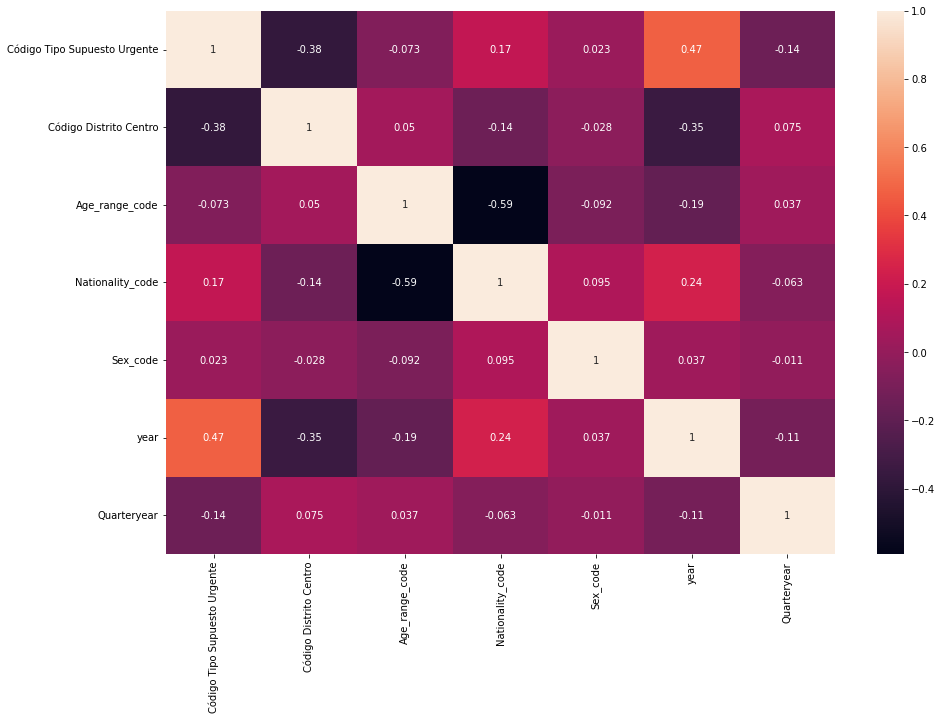

In [65]:
plt.figure(figsize=(15,10))
sns.heatmap(df_urgencias_corregido_prueba.corr(), annot=True);

Se observa que hay cierta correlación entre los parámetros de **year**, **Nationality_code**,**Código Distrito Centro**.

También se observa que no hay aparente correlación con los parámetros **Código Tipo Atención**,**Age_range_code** y **Sex_code**.

**year** también parece tener correlación con otros parámetros como **Nationality_code** o **Código Distrito centro**.

**Nationality code** y **Age_range_code** parece que también tiene una cierta correlación.

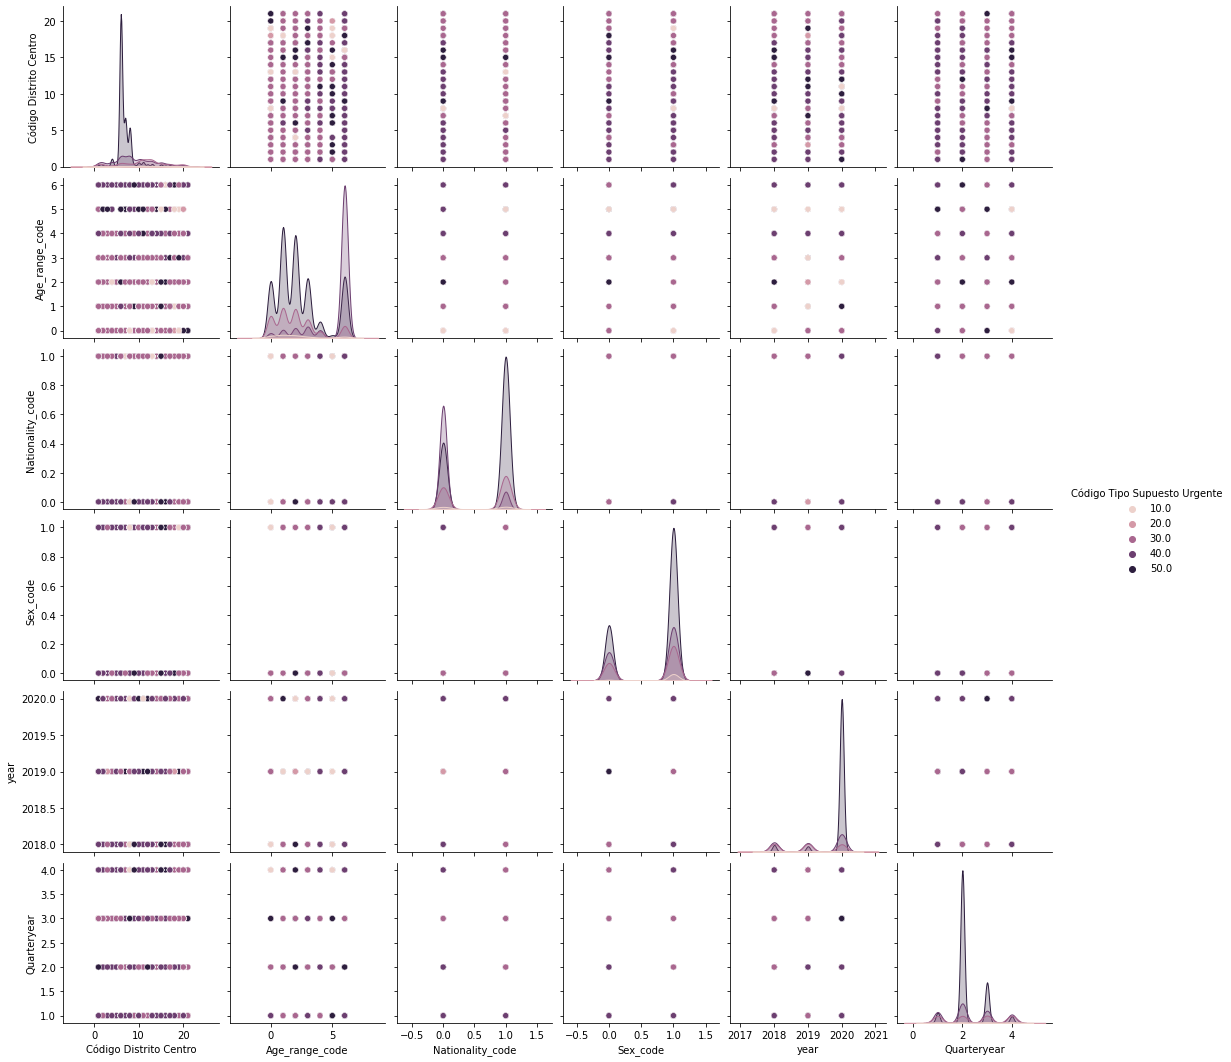

In [66]:
sns.pairplot(df_urgencias_corregido_prueba,hue='Código Tipo Supuesto Urgente');

En este **pairplot** se ve claramente que los valores no son continuos, sino discretos.

Hay que tener esto en cuenta a la hora de realizar cualquier análisis y predicción, ya que habrá que hacer __clasificación__.

También se observa que datos de cada variable han dado más resultados en relación con la variable target (Código Tipo Supuesto Urgente).

En este sentido cabe destacar los altos valores en el segundo trimestre del 2020, debido al estado de excepción provocado por el COVID-19, por el cierre de muchos negocios y que es la causa principal de muchas de las demandas en los Centros de Atención Primaria en el país, desde esta fecha en adelante.

<Figure size 1080x720 with 0 Axes>

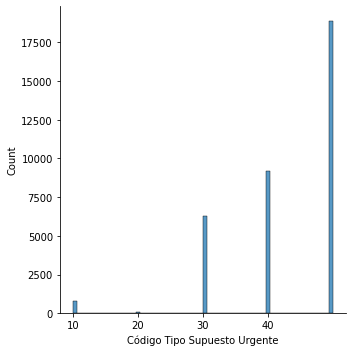

In [68]:
plt.figure(figsize=(15,10))
sns.displot(df_urgencias_corregido_prueba['Código Tipo Supuesto Urgente'])
plt.xticks(np.arange(10,50,step=10));

- #### 6.2- Aqui se observan diversas gráficas para un estudio preliminar que hemos realizado con **Tableau** referente a los diferentes parametros en relación con la variable objetivo.

![Aqui se observa como evolucionan los distintos casos en el periodo de estudio](./resources/img/Tipologia_casos.png)

![Aqui se observa como evolucionan los distintos casos en el periodo de estudio](./resources/img/Tipologia_casos_por_distrito.png)

En este gráfico se puede ver que en determinados distritos las urgencias a tratar son más bajas que en otros distritos.

También se observa que como *regla general* en todos los distritos las urgencias más atendidas son:

> Desprotección social problema salud
>
> Desprotección socio-familiar
>
> Alojamiento/Vivienda

![Aqui se observa como evoluciona en el tiempo las atenciones de urgencia](./resources/img/Edades.png)


En este gráfico se puede ver que antes del Covid-19 no había practicamente demandas y con el surgimiento del Covid-19 se disparan las mismas en proporciones similares tramo a tramo.

![Aqui se observa como evolucionan los distintos casos en el periodo de estudio](./resources/img/Nacionalidad.png)

En este gráfico se ve lo mismo que en el anterior, como en el segundo trimetre del 2020, justo con el aislamiento general decretado por el gobierno, se produce un aumento significativo de las urgencias.

A su vez se ve que éstas son mas demandadas por los extranjeros que por los españoles.

![Aqui se observa como evolucionan los distintos casos en el periodo de estudio](./resources/img/Sexo.png)

En este gráfico hemos añadido una **línea de regresión de tipo exponencial** para ver como se comporta ante el rápido crecimiento de solicitudes en el 2020.

Otra alternativa para valorar sería una ***línea de regresión polinomial de grado n***.

### 7.- Checking models

Vamos a realizar varios modelados con módelos clasificatorios para con las métricas adecuadas, valorar cuales se aproximan mejor a las clasificaciones de las urgencias atendidas y en el siguiente punto proceder a una optimización de las mejores.

Estos módelos que vamos a realizar son:

> Logistic Regresion
>
> DecisionTreeClassifier
>
> BaggingClassifier de DecisionTreeClassifier  
>
> Random Forest
>
> K-Nearest Neighbours          (pendiente de realizar)
>
> AdaBoostClassifier
>
> GradientBoostingClassifier

Aqui representamos las métricas más importantes de las mismas.

Dado que nuestro Datasets está desbalanceado, tomaremos en cuenta el **F1 Score, Precisión y Recall** para valorar como de bien se toman los valores de True Positive en cada valor de la variable Target.

### 8.- Optimize best models

Vamos a proceder a realizar un Grid Search con los 3 mejores modelos de clasificación de los que hemos obtenido los datos con mejores métricas.

## CONCLUSIÓN: